In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
from dotenv import load_dotenv
from urllib.parse import unquote

In [2]:
class Study:
    def __init__(self, file_id, title, condition):
        self.file_id = file_id
        self.title= title
        self.condition = condition

class Drug:
    def __init__(self, name):
        self.name = name
        self.moa_urls = []
        self.act_urls = []
        self.files = []
        self.mesh_info = None
        self.struct_id = None


class MeshElement:
    def __init__(self, descriptor_name, descriptor_ui):
        self.descriptor_name = descriptor_name
        self.descriptor_ui = descriptor_ui

In [3]:
# Load the environment variables from the .env file
load_dotenv()

xml_folder_path = os.getenv('TEST_FILES')
tsv_file = os.getenv('FILE_TSV')
MeSH_file = os.getenv('MeSH')

# RDF graph
graph = Graph()

# Define RDF namespaces and bind
CT = Namespace("https://clinicaltrials.gov/")
DRUG_CARD = Namespace("https://drugcentral.org/drugcard/")
SCHEMA = Namespace("https://schema.org/")
STUDY = Namespace("https://clinicaltrials.gov/ct2/show/")
MESH = Namespace("https://www.ncbi.nlm.nih.gov/mesh/?term=")

graph.bind('ct', CT)
graph.bind('drug', DRUG_CARD)
graph.bind('file', STUDY)
graph.bind('mesh', MESH)
graph.bind('schema', SCHEMA)

context = {
    "ct": "https://clinicaltrials.gov/",
    "drug": "https://drugcentral.org/drugcard/",
    "file": "https://clinicaltrials.gov/ct2/show/",
    "mesh": "https://www.ncbi.nlm.nih.gov/mesh/?term=",
    "schema": "https://schema.org/"
}

# Add the context to your RDF graph
graph.namespace_manager.context = context

# Dictionary to store information associated with each drug
drugs_info = {}

# Set to store drugs not present in the TSV
missing_drugs = set()

In [4]:
# Iterate over all XML studies files
for filename in os.listdir(xml_folder_path):
    if filename.endswith('.xml'):
        xml_file_path = os.path.join(xml_folder_path, filename)

        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        # Extract information from the XML file
        intervention_type = root.find('.//intervention_type')
        intervention_name = root.find('.//intervention_name')

        # Check if the intervention_type field is "drug"
        if intervention_type is not None and intervention_type.text.lower() == 'drug':
            # Initialize the drug object if it does not exist
            drug_name = intervention_name.text.lower()
            drug_name_uri = '_'.join(drug_name.split())

            

            if root.find('.//official_title') is not None:
                study_title = root.find('.//official_title').text
            else:
                study_title = root.find('.//brief_title').text
                
            study_condition = root.find('.//condition').text

            if drug_name_uri not in drugs_info:
                drugs_info[drug_name_uri] = Drug(drug_name)

            # Add the current file to the list of files associated with the drug
            drugs_info[drug_name_uri].files.append(Study(filename, study_title, study_condition))

In [5]:
# Read the TSV file with drug information
with open(tsv_file, 'r') as tsv_file:
    tsv_data = pd.read_csv(tsv_file, delimiter='\t')

# Filter the data to include only drugs mentioned in the XML files
tsv_data = tsv_data[tsv_data['DRUG_NAME'].str.lower().isin(drugs_info.keys())]

# Iterate over drugs in the XML files
for index, row in tsv_data.iterrows():
    drug_name = row['DRUG_NAME']
    moa_source_url = row['MOA_SOURCE_URL']
    act_source_url = row['ACT_SOURCE_URL']
    struct_id = row['STRUCT_ID']

    # Replace spaces with underscores to create valid URIs
    drug_name_uri = '_'.join(drug_name.split())

    # Normalize URLs
    moa_source_url = unquote(str(moa_source_url))
    act_source_url = unquote(str(act_source_url))

    # Add information to the Drug object for the drug
    if drug_name_uri in drugs_info:
        drug_obj = drugs_info[drug_name_uri]

        # Append MOA URLs and ACT URLs to the Drug object
        drug_obj.moa_urls.append(Literal(moa_source_url) if not pd.isna(moa_source_url) else Literal(None))
        drug_obj.act_urls.append(Literal(act_source_url) if not pd.isna(act_source_url) else Literal(None))

        # Set the struct_id for the Drug object
        drug_obj.struct_id = struct_id


In [6]:
# Read the MeSH XML file
mesh_tree = ET.parse(MeSH_file)
mesh_root = mesh_tree.getroot()

for drug_name_uri, drug_info in drugs_info.items():
    drug_name = drug_name_uri.replace('_', ' ')
    struct_id = drug_info.struct_id

    # Search for drug_name in MeSH XML
    for descriptor_record in mesh_root.findall('.//DescriptorRecord'):
        descriptor_name = descriptor_record.find('.//DescriptorName/String')
        if descriptor_name is not None and descriptor_name.text.lower() == drug_name.lower():
            # Drug found in MeSH XML, extract information
            descriptor_ui = descriptor_record.find('.//DescriptorUI')
            if descriptor_ui is not None:
                # Create MeshElement instance and add MeSH information to the Drug object
                mesh_element = MeshElement(descriptor_name.text, descriptor_ui.text)
                drug_info.mesh_info = mesh_element
                break

In [7]:
for drug_name_uri, info in drugs_info.items():
    # Check if the drug is missing in the TSV
    if drug_name_uri not in [name.lower().replace(' ', '_') for name in tsv_data['DRUG_NAME']]:
        missing_drugs.add(drug_name_uri)
        continue

    drug = Drug(drug_name_uri.replace('_', ' '))
    drug_uri = URIRef(DRUG_CARD[repr(info.struct_id)]) 

    graph.add((drug_uri, RDF.type, SCHEMA.Drug))
    graph.add((drug_uri, RDFS.label, Literal(drug.name)))

    # Handling MOA URLs
    for moa_url in info.moa_urls:
        if moa_url.lower() != 'nan':
            drug.moa_urls.append(Literal(moa_url))
            graph.add((drug_uri, SCHEMA.url, Literal(moa_url)))

    # Handling ACT URLs
    for act_url in info.act_urls:
        if act_url.lower() != 'nan':
            drug.act_urls.append(Literal(act_url))
            graph.add((drug_uri, SCHEMA.url, Literal(act_url)))

    # Connecting files to the drug node
    for doc in info.files:
        file_id = doc.file_id[:-4]
        study = Study(file_id, doc.title, doc.condition)
        file_uri = URIRef(STUDY[file_id])

        graph.add((file_uri, RDF.type, SCHEMA.MedicalStudy))
        graph.add((file_uri, RDFS.label, Literal(study.title)))
        graph.add((file_uri, SCHEMA.MedicalCondition, Literal(study.condition)))
        graph.add((drug_uri, SCHEMA.study, file_uri))


    # Adding MeSH information
    mesh_info = info.mesh_info
    if mesh_info is not None and isinstance(mesh_info, MeshElement):
        descriptor_uri = URIRef(MESH[mesh_info.descriptor_ui])
        graph.add((drug_uri, SCHEMA.url, descriptor_uri))

In [8]:
# Serialize the RDF graph in JSON-LD format
# jsonld_data = graph.serialize(format='json-ld', indent=4)
jsonld_data = graph.serialize(format='json-ld', context=context, indent=4)

print(jsonld_data)

# print("\n\n",len(missing_drugs)," Drugs not present in TSV:", missing_drugs)

# Save the result to a JSON-LD file
with open('output.jsonld', 'w') as f:
    f.write(jsonld_data)

{
    "@context": {
        "ct": "https://clinicaltrials.gov/",
        "drug": "https://drugcentral.org/drugcard/",
        "file": "https://clinicaltrials.gov/ct2/show/",
        "mesh": "https://www.ncbi.nlm.nih.gov/mesh/?term=",
        "schema": "https://schema.org/"
    },
    "@graph": [
        {
            "@id": "drug:480",
            "@type": "schema:Drug",
            "http://www.w3.org/2000/01/rdf-schema#label": "capecitabine",
            "schema:study": {
                "@id": "file:NCT00010023"
            },
            "schema:url": [
                "https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL1773",
                {
                    "@id": "https://www.ncbi.nlm.nih.gov/mesh/?term=D000069287"
                }
            ]
        },
        {
            "@id": "drug:1122",
            "@type": "schema:Drug",
            "http://www.w3.org/2000/01/rdf-schema#label": "exemestane",
            "schema:study": {
                "@id": "file:NCT00010010

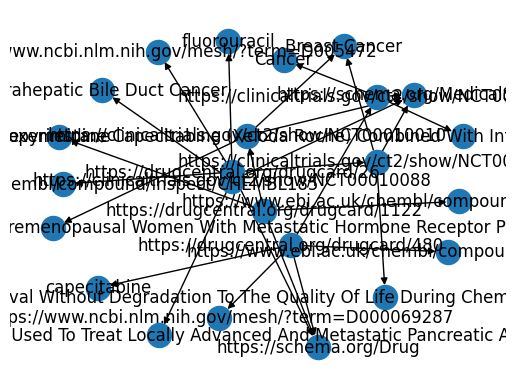

In [21]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt


g = Graph()
result = g.parse('output.jsonld', format='json-ld')

G = rdflib_to_networkx_multidigraph(result)

# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=2)
edge_labels = nx.get_edge_attributes(G, 'r')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=True)

#if not in interactive mode for 
plt.show()